In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

2021-11-18 19:41:19.632937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-18 19:41:19.633001: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_gen = ImageDataGenerator()

train_ds = train_gen.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.


In [4]:
train_ds.class_indices

{'cats': 0, 'dogs': 1}

In [5]:
#idem for validation data
val_gen = ImageDataGenerator()

val_ds = val_gen.flow_from_directory(
    './validation',
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary',
    shuffle=False
)

Found 5000 images belonging to 2 classes.


In [6]:
# neural network architecture (functional style)
from tensorflow.keras import layers
from tensorflow.keras import initializers

inputs = keras.Input(shape=(150, 150, 3))

inner = layers.Conv2D(32, 3, activation='relu')(inputs)
inner2 = layers.MaxPooling2D(pool_size=(2, 2))(inner)
vectors = layers.Flatten()(inner2)
inner3 = layers.Dense(
    64, 
    activation='relu', 
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()
 )(vectors)

outputs = layers.Dense(1, activation='sigmoid')(inner3)

model = keras.Model(inputs, outputs)

2021-11-18 19:41:25.591814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-18 19:41:25.592311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-18 19:41:25.592503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-18 19:41:25.592611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-18 19:41:25.592688: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [7]:
optimizer = keras.optimizers.SGD(
    learning_rate=0.002, 
    momentum=0.8
)

model.compile(
    optimizer=optimizer, 
    loss=keras.losses.BinaryCrossentropy(), 
    metrics=[keras.metrics.BinaryAccuracy()]
    )

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

### 1st round

In [9]:
gen = ImageDataGenerator(
    rescale=1./255
)

train_ds = gen.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary'
)

val_ds = gen.flow_from_directory(
    './validation',
    target_size=(150, 150),
    batch_size=20,
    class_mode = 'binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
history = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 28s 270ms/step - loss: 0.6917 - binary_accuracy: 0.5425 - val_loss: 0.7855 - val_binary_accuracy: 0.1410
Epoch 2/10
100/100 [==============================] - 24s 239ms/step - loss: 0.6822 - binary_accuracy: 0.5595 - val_loss: 0.7881 - val_binary_accuracy: 0.2460
Epoch 3/10
100/100 [==============================] - 23s 226ms/step - loss: 0.6715 - binary_accuracy: 0.5735 - val_loss: 0.7175 - val_binary_accuracy: 0.4450
Epoch 4/10
100/100 [==============================] - 23s 225ms/step - loss: 0.6643 - binary_accuracy: 0.5930 - val_loss: 0.8650 - val_binary_accuracy: 0.1890
Epoch 5/10
100/100 [==============================] - 23s 227ms/step - loss: 0.6596 - binary_accuracy: 0.6050 - val_loss: 0.4131 - val_binary_accuracy: 0.9800
Epoch 6/10
100/100 [==============================] - 22s 222ms/step - loss: 0.6523 - binary_accuracy: 0.6010 - val_loss: 0.7753 - val_binary_accuracy: 0.3890
Epoch 7/10
100/100 [==========================

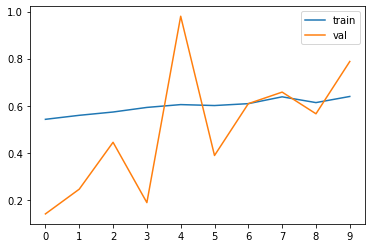

In [11]:
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [12]:
from scipy import stats

stats.describe(np.array(history.history['binary_accuracy']))

DescribeResult(nobs=10, minmax=(0.5425000190734863, 0.6395000219345093), mean=0.5974500060081482, variance=0.0009918032613757393, skewness=-0.3270625398989527, kurtosis=-0.8113251129175292)

In [13]:
# median of training accuracy
np.median(history.history['binary_accuracy'])

0.6030000150203705

In [14]:
# standard deviation of training loss
np.std(history.history['loss'])

0.018378598223205152

### 2nd round

In [15]:
gen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

train_ds = gen2.flow_from_directory(
    './train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
    )

val_ds = gen2.flow_from_directory(
    './validation',
    target_size=(150, 150),
    batch_size=20,
    shuffle=False,
    class_mode='binary'
    )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [16]:
history2 = model.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_ds,
    validation_steps=50
)

Epoch 1/10
100/100 [==============================] - 27s 270ms/step - loss: 0.6636 - binary_accuracy: 0.5915 - val_loss: 0.5766 - val_binary_accuracy: 0.7820
Epoch 2/10
100/100 [==============================] - 28s 276ms/step - loss: 0.6643 - binary_accuracy: 0.5880 - val_loss: 0.6308 - val_binary_accuracy: 0.7020
Epoch 3/10
100/100 [==============================] - 29s 292ms/step - loss: 0.6522 - binary_accuracy: 0.6145 - val_loss: 0.8127 - val_binary_accuracy: 0.3310
Epoch 4/10
100/100 [==============================] - 28s 283ms/step - loss: 0.6638 - binary_accuracy: 0.5835 - val_loss: 0.6675 - val_binary_accuracy: 0.5830
Epoch 5/10
100/100 [==============================] - 28s 279ms/step - loss: 0.6559 - binary_accuracy: 0.5915 - val_loss: 0.8163 - val_binary_accuracy: 0.2880
Epoch 6/10
100/100 [==============================] - 28s 281ms/step - loss: 0.6539 - binary_accuracy: 0.6120 - val_loss: 0.5279 - val_binary_accuracy: 0.8750
Epoch 7/10
100/100 [==========================

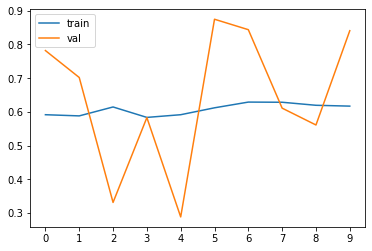

In [17]:
plt.plot(history2.history['binary_accuracy'], label='train')
plt.plot(history2.history['val_binary_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [18]:
np.mean(history2.history['val_loss'])

0.6457361102104187

In [19]:
np.average(history2.history['val_binary_accuracy'][5:])

0.746399998664856